In [14]:
import re
import unicodedata

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from rake_nltk import Rake
import rake_nltk
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juanp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
with open('data\\data_scientist.txt','r', encoding='utf-8') as f:
    info = f.readlines()

info = '\n'.join(info)
info = info.split('|----------|')
info = info[1:]

In [3]:
def count_nonempty(desc):
    counter = 0
    for d in desc.split('\n'):
        if d != '':
            counter += 1
    return counter


def drop_eeo(desc):
    if count_nonempty(desc) <= 1:
        return desc
    new_desc = []
    for d in desc.split('\n'):
        if not(('equal employment opportunity' in d) or ('equal opportunity employer' in d)):
            new_desc.append(d)
    return '\n'.join(new_desc)


def find_block(desc,ini_word,end_word):
    limits = []
    for i, line in enumerate(desc):
        if line == ini_word:
            limits.append(i)
        elif line == end_word:
            limits.append(i)
    return limits
    
    
def process_DealerPolicy(desc):
    desc = desc.split('\n')
    limits = find_block(desc,'Responsibilities','Benefits')
    desc = desc[limits[0]:limits[1]]
    return '\n'.join(desc)


def process_Addepar(desc):
    desc = desc.split('\n')
    limits = find_block(desc,'The Role','About Addepar')
    if len(limits) != 2:
        limits = find_block(desc,'Responsibilities','About Addepar')
    desc = desc[limits[0]:limits[1]]
    return '\n'.join(desc)


def process_Dice(desc):
    desc = desc.split('\n')
    return '\n'.join(desc[4:])

In [103]:
urls = []
titles = []
companies = []
locations = []
descriptions = []
basic_info = []

for tmp in info:
    tmp_information = tmp.split('\n')
    
    url = tmp_information[4]
    title = tmp_information[6]
    company = tmp_information[8]
    location = tmp_information[10]
    
    basic_info.append([title, company, location, url])
    urls.append(url)
    titles.append(title)
    companies.append(company)
    locations.append(location)
    if company == 'DealerPolicy':
        description = process_DealerPolicy('\n'.join(tmp_information[12:]))
    elif company == 'Dice':
        description = process_Dice('\n'.join(tmp_information[12:]))
    elif company == 'Addepar':
        description = process_Addepar('\n'.join(tmp_information[12:]))
    else:
        description = '\n'.join(tmp_information[12:])
        
#     descriptions.append(description)
    descriptions.append(drop_eeo(description.lower()))

In [104]:
df_offers = pd.DataFrame(basic_info, columns = ['title','company','location','url'])
df_offers['title'] = df_offers['title'].str.lower()
df_offers

,title,company,location,url
0,senior cyber supply chain risk modeler/data sc...,Guidewire Software,United States,https://www.linkedin.com/company/9624/
1,remote data scientist - merchant analytics,RITE AID,"Camp Hill, PA",https://www.linkedin.com/company/6913/
2,"data scientist (100% remote for now, will requ...",The Mom Project,"Menlo Park, CA",https://www.linkedin.com/company/10420321/
3,data scientist / operations research scientist...,Vroom,"New York, NY",https://www.linkedin.com/company/3107677/
4,software engineer (entry level),Tata Consultancy Services,"Tennessee, United States",https://www.linkedin.com/company/1353/
...,...,...,...,...
966,software engineer (remote),Q² Solutions,"Columbia, MD",https://www.linkedin.com/company/10396016/
967,kafka software engineer (remote),KeyBank,"Ashland, Ohio, United States",https://www.linkedin.com/company/3252/
968,software engineer (full stack),Woflow,"San Francisco, CA",https://www.linkedin.com/company/18532450/
969,data scientist,Woflow,"San Francisco, CA",https://www.linkedin.com/company/18532450/


In [105]:
df_offers['company'].value_counts().head(30)

DealerPolicy                 74
Dice                         60
Addepar                      34
Docker, Inc                  32
HashiCorp                    30
Degreed                      26
Zillow                       17
Virgin Pulse                 14
Collibra                     13
HomeAdvisor                  13
Vroom                        12
Tata Consultancy Services    10
GE Healthcare                10
Mode                          9
Leidos                        8
The Mom Project               8
ClearanceJobs                 7
Horizontal Talent             6
Wiley                         6
GovernmentCIO                 6
Confluent                     6
Securly                       6
JW Player                     6
Koch Industries               6
Clari                         6
Catalent Pharma Solutions     6
iboss                         5
LHC Group                     5
Magic Leap                    5
Landmark Health               5
Name: company, dtype: int64

In [106]:
df_offers[df_offers['company'] == 'DealerPolicy']['title'].value_counts()

software engineer - remote    74
Name: title, dtype: int64

In [107]:
se_titles = set(df_offers[df_offers['title'].str.contains('software')]['title'].values.tolist())
df_tmp = df_offers[df_offers['title'].str.contains('software')]
exceptions = set(df_tmp[df_tmp['title'].str.contains('data|machine learning', regex = True)]['title'].values.tolist())
se_titles = list(se_titles.difference(exceptions))

In [108]:
descriptions = [d for i, d in enumerate(descriptions) if (~(df_offers['title'].isin(se_titles))).values[i]]
df_offers = df_offers[~(df_offers['title'].isin(se_titles))]

In [109]:
for i, value in df_offers[df_offers['title'].str.contains('software engineer')]['title'].value_counts().iteritems():
    print(value, i)

6 software engineer - data import services
4 fullstack software engineer - data quality
1 software engineer, data analytics platform (remote)
1 software engineer, data pipelines
1 remote: software engineer - database developer
1 software engineer (backend/data) *fully remote*
1 software engineer - etl/data (remote accepted)
1 software engineer, data streaming-remote


In [110]:
df_offers

,title,company,location,url
0,senior cyber supply chain risk modeler/data sc...,Guidewire Software,United States,https://www.linkedin.com/company/9624/
1,remote data scientist - merchant analytics,RITE AID,"Camp Hill, PA",https://www.linkedin.com/company/6913/
2,"data scientist (100% remote for now, will requ...",The Mom Project,"Menlo Park, CA",https://www.linkedin.com/company/10420321/
3,data scientist / operations research scientist...,Vroom,"New York, NY",https://www.linkedin.com/company/3107677/
6,data scientist,Paylocity,United States,https://www.linkedin.com/company/24614/
...,...,...,...,...
956,"software development engineer, big data - prop...",Zillow,United States,https://www.linkedin.com/company/13990/
957,reporting and data engineer - remote - 21-04962,Infinity Consulting Solutions,"El Paso, TX",https://www.linkedin.com/company/49291/
962,[foundations] data engineer,"Checkr, Inc.","San Francisco, CA",https://www.linkedin.com/company/3535535/
969,data scientist,Woflow,"San Francisco, CA",https://www.linkedin.com/company/18532450/


In [111]:
sw = stopwords.words('english') + ['long', 'descriptive', 'text', 'contains', 'technical', 'skills', 'keywords', 'things', 'see', 'rake', 'need', 'many', 'lists', 'let', 'extract']

def preprocess_text(text, sw):
    wnl = nltk.WordNetLemmatizer()
    text = (unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8', 'ignore').lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [word for word in words if word not in sw]

In [136]:
n = 1
data_frames = []

for desc in descriptions:
    words = preprocess_text(desc, sw)
    data_frames.append(pd.Series(list(set(list(nltk.ngrams(words,n))))).value_counts().reset_index().rename(columns={'index': 'n-gram', 0: 'count'}))
    
df = pd.concat(data_frames).groupby('n-gram').sum().sort_values(by = 'count', ascending = False)

for i, row in df.head(20).iterrows():
    print(row['count'], end = ' ')
    print(*i, sep = ' ')

429 experience
412 data
358 work
344 team
338 business
314 years
298 working
271 sql
267 role
264 development
263 solutions
262 support
262 knowledge
257 including
255 company
250 python
247 engineering
247 strong
241 teams
240 environment


In [137]:
n = 2
data_frames = []

for desc in descriptions:
    words = preprocess_text(desc, sw)
    data_frames.append(pd.Series(list(set(list(nltk.ngrams(words,n))))).value_counts().reset_index().rename(columns={'index': 'n-gram', 0: 'count'}))
    
df = pd.concat(data_frames).groupby('n-gram').sum().sort_values(by = 'count', ascending = False)

for i, row in df.head(20).iterrows():
    print(row['count'], end = ' ')
    print(*i, sep = ' ')

182 years experience
148 computer science
140 experience working
132 data science
120 experience data
110 bachelors degree
110 machine learning
109 2 years
108 3 years
105 data engineering
97 data engineer
95 dental vision
92 best practices
92 ability work
87 data scientist
86 data sets
85 data analytics
84 sexual orientation
83 data warehouse
82 national origin


In [138]:
r = Rake(
    ranking_metric = rake_nltk.Metric.DEGREE_TO_FREQUENCY_RATIO,
    stopwords = stopwords.words('english') + ['long', 'descriptive', 'text', 'contains', 'technical', 'skills', 'keywords', 'things', 'see', 'rake', 'need', 'many', 'lists', 'let', 'extract']
)

all_descriptions = '\n'.join(descriptions)
r.extract_keywords_from_text(all_descriptions)

phrases_scores = r.get_ranked_phrases_with_scores()

for score, phrase in phrases_scores[:20]:
    print(score, phrase)

204.21696428571428 manager recruitment 116 village blvd bull suite 200 bull princeton bull new jersey bull 08540 direct office ext 104 httpswww
183.68066875653082 eeoc poster eeoc gina supplement ofccp eeo supplement pay transparency nondiscrimination search firm representatives please read carefully merck
139.87562596624088 itil process implementation experience supporting dhs mission space desired certifications servicenow automated test framework fundamentals servicenow system administrator servicenow implementation specialist servicenow application developer governmentcio
109.01496857169772 paid volunteer hours diversity alliance resource groups employee stock purchase program tuition reimbursement charitable gift matching job required equipment
95.77165121749799 employer contribution employee stock option plan uncapped pto parental leave flexible working options home office allowance work
84.52013138237352 technology stack knowledge tableau visualization wherescape required talend

In [115]:
keyword_list = [
    'sql','python','aws','java','c','azure','javascript','react','docker','api','apis','rest','restful',
    'kubernetes','git','github','spark','saas','google','tableau','r','css','nodejs','ruby','linux', 'unix'
    'airflow', 'scala', 'hive', 'presto', 'snowflake', 'kafka', 'looker', 'amplitude', 'tensorflow', 'pytorch',
    'oracle', 'css', 'angular'
]

n = 1
data_frames = []

for desc in descriptions:
    words = preprocess_text(desc, sw)
    data_frames.append(pd.Series(list(set(list(nltk.ngrams(words,n))))).value_counts().reset_index().rename(columns={'index': 'n-gram', 0: 'count'}))
    
df = pd.concat(data_frames).groupby('n-gram').sum().sort_values(by = 'count', ascending = False)
df = df.reset_index()
df['n-gram'] = df['n-gram'].apply(lambda x: x[0])
df_red = df[df['n-gram'].isin(keyword_list)]

for i, row in df_red.iterrows():
    print(row['count'], row['n-gram'])
    
df_red = df_red.rename(columns = {'n-gram':'keyword'})
df_error = df_red.copy()

271 sql
250 python
117 aws
92 spark
84 tableau
84 java
76 r
73 snowflake
72 azure
55 apis
52 javascript
48 c
48 git
48 kafka
39 docker
37 api
33 google
31 scala
29 amplitude
28 rest
27 looker
24 kubernetes
24 oracle
23 tensorflow
23 react
22 saas
21 pytorch
19 hive
18 linux
15 css
15 angular
14 github
12 nodejs
10 restful
6 presto
3 ruby


In [116]:
n = len(descriptions)
z = 1.96
df_error['p'] = df['count']/n
df_error['moe'] = df_error['p'].apply(lambda p: z * np.sqrt((p*(1-p))/n))
df_error

,keyword,count,p,moe
7,sql,271,0.603563,0.045246
15,python,250,0.556793,0.045950
132,aws,117,0.260579,0.040602
225,spark,92,0.204900,0.037335
260,tableau,84,0.187082,0.036072
267,java,84,0.187082,0.036072
307,r,76,0.169265,0.034685
325,snowflake,73,0.162584,0.034130
339,azure,72,0.160356,0.033941
476,apis,55,0.122494,0.030326


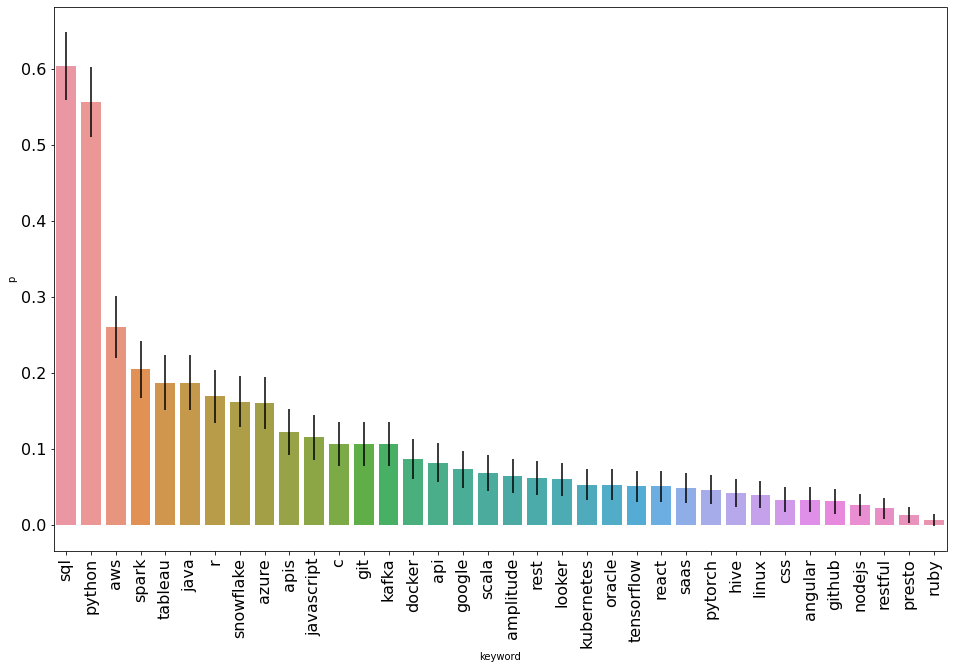

In [117]:
fig, ax = plt.subplots(figsize = (16,10))

ax = sns.barplot(x = "keyword", y = "p", data = df_error, yerr = df_error['moe'])
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);